In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch_geometric.graphgym.utils import epoch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from transformers import PreTrainedModel, PretrainedConfig
import torch.nn.functional as F

import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "mps"


Construction du classifieur

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 classes pour MNIST
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc_layers(x)  # Logits



In [6]:
classifier = Classifier().to(device)
# Chargement des données MNIST
train_loader = DataLoader(datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True), batch_size=64, shuffle=True)
test_loader = DataLoader(datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True), batch_size=64, shuffle=True)

Entraînement du CNN

In [5]:
from tqdm.notebook import tqdm


optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def train_classifier():
    # Entraînement
    classifier.train()
    for epoch in range(10):
        total_loss = 0
        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = classifier(imgs)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

    # Sauvegarde du modèle entraîné
    torch.save(classifier.state_dict(), "mnist_classifier.pth")

train_classifier()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1726


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0490


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0345


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0251


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0193


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0141


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0123


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0086


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0088


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0066


tensor([-20.1376, -10.1747,  -8.9877,  24.3271, -27.5527,   1.1627, -19.3646,
         -8.3662,   2.0907,   0.2383], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='mps:0')


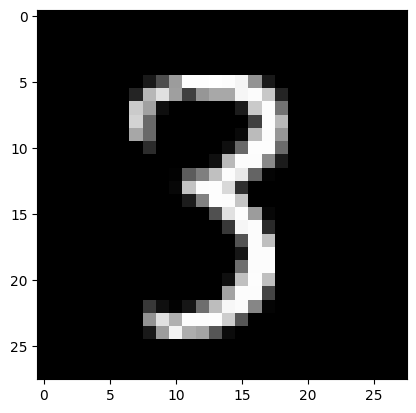

In [7]:
# TEST VISUEL

classifier.load_state_dict(torch.load("mnist_classifier.pth", weights_only=True))
classifier.eval()
batch = next(iter(train_loader))
imgs, labels = batch
imgs, labels = imgs.to(device), labels.to(device)
logits = classifier(imgs)

print(logits[0])
print(labels[0])
plt.imshow(imgs.squeeze().cpu().numpy()[0], cmap='gray')
plt.show()

Déterminer la qualité du classifieur

In [35]:
classifier.eval()  # Met le modèle en mode évaluation
correct = 0
total = 0
test_loss = 0
max_logits_list = []

with torch.no_grad():  # Pas de calcul de gradients
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = classifier(images)
        loss = F.cross_entropy(outputs, labels)  # Calcul de la loss
        test_loss += loss.item() * images.size(0)  # Cumul de la loss pondérée

        max_logits, _ = torch.max(outputs, dim=1)  # Max logit pour chaque image du batch
        max_logits_list.append(max_logits)

        _, predicted = torch.max(outputs, 1)  # Prédictions finales
        correct += (predicted == labels).sum().item()  # Comptage des bonnes réponses
        total += labels.size(0)  # Total d'images testées


all_max_logits = torch.cat(max_logits_list)  # [N_total]
mean_max_logit = all_max_logits.mean().item()
avg_loss = test_loss / total
accuracy = correct / total * 100  # Précision en %

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Mean max logit: {mean_max_logit:.4f}")


Test Loss: 0.0361
Test Accuracy: 98.91%
Mean max logit: 18.9480


Chargement des images générées

In [39]:
import os
from PIL import Image
import torch
from torchvision import transforms

def load_generated_images(folder, img_size=(28, 28)):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convertir en RGB si besoin
        transforms.Resize(img_size),  # Redimensionner si nécessaire
        transforms.ToTensor(),  # Convertir en tensor [0,1]
    ])

    images = []
    filenames = sorted(os.listdir(folder))  # Trier pour cohérence
    for file in filenames:
        img_path = os.path.join(folder, file)
        img = Image.open(img_path)
        img = transform(img)  # Appliquer les transformations
        images.append(img)

    return torch.stack(images)  # Retourne un batch de tensors

# Charger les images des différents modèles
vae_images = load_generated_images("VAE_generated/").to(device)
gan_images = load_generated_images("GAN_generated/").to(device)
ddpm_images = load_generated_images("DDPM_generated/").to(device)

print(vae_images.shape)
print(gan_images.shape)
print(ddpm_images.shape)


torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


Calcul des mean_max_logits sur les générés

In [64]:
scores_mml = []
for groupe in [vae_images, gan_images, ddpm_images]:
    logits = classifier(groupe)
    scores_mml.append(torch.max(logits, dim=1).values.mean().detach().cpu().numpy().item())

print(f"Scores mml VAE: {scores_mml[0]:.4f}")
print(f"Scores mml GAN: {scores_mml[1]:.4f}")
print(f"Scores mml DDPM: {scores_mml[2]:.4f}")

Scores mml VAE: 11.1808
Scores mml GAN: 11.0247
Scores mml DDPM: 12.7437


Calcul de la variété

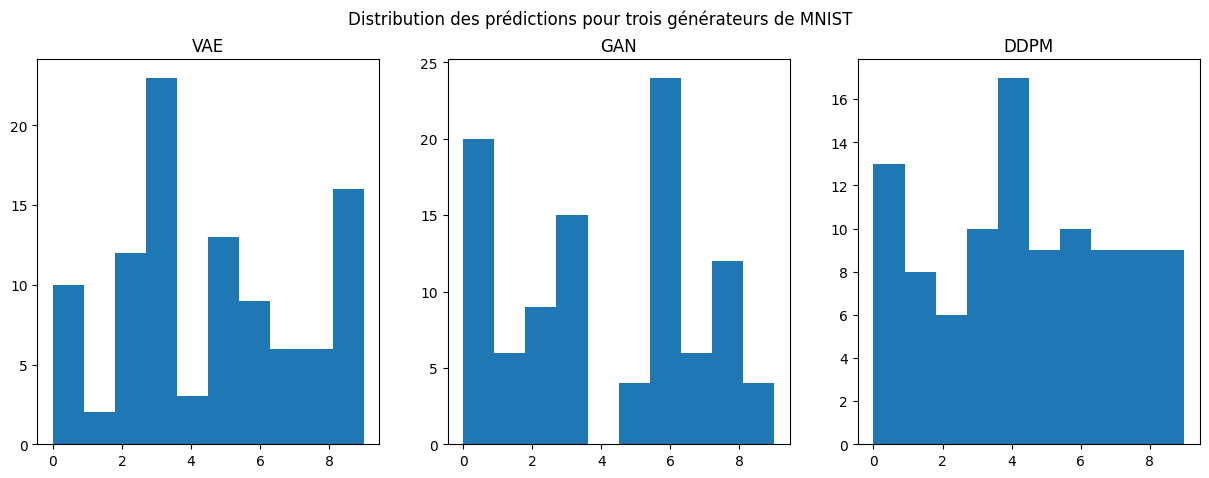

In [92]:
def get_predictions(images):

    predicted_labels = torch.argmax(classifier(images), dim=1)
    predicted_list = predicted_labels.cpu().numpy().tolist()
    return predicted_list

list_predictions_vae = get_predictions(vae_images)
list_predictions_gan = get_predictions(gan_images)
list_predictions_ddpm = get_predictions(ddpm_images)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(list_predictions_vae)
axs[0].title.set_text("VAE")
axs[1].hist(list_predictions_gan)
axs[1].title.set_text("GAN")
axs[2].hist(list_predictions_ddpm)
axs[2].title.set_text("DDPM")

fig.suptitle("Distribution des prédictions pour trois générateurs de MNIST")
plt.savefig("distribution.png")


Quelques rendus de type "notre meilleur" etc

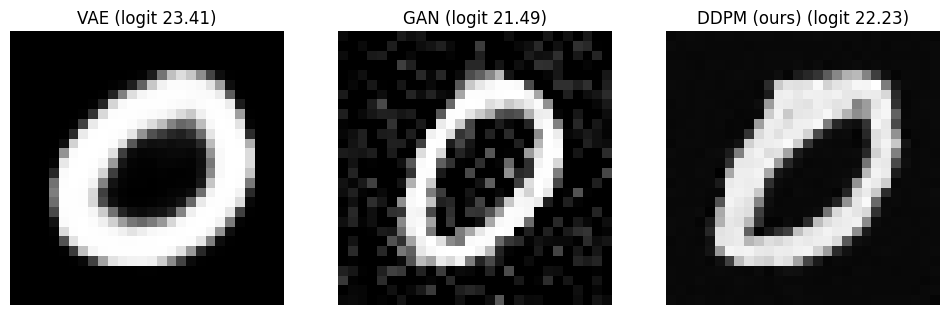

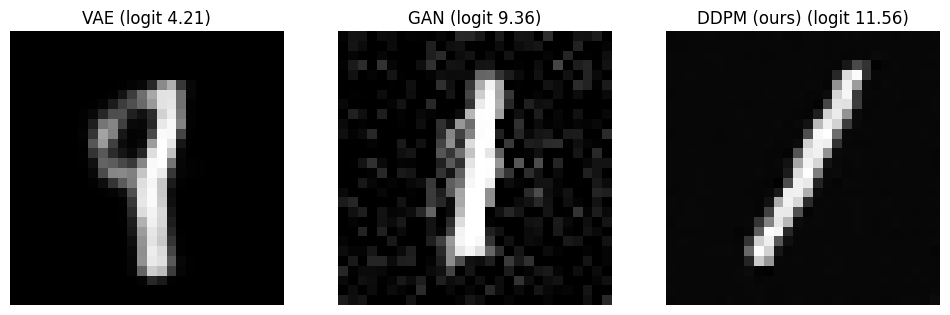

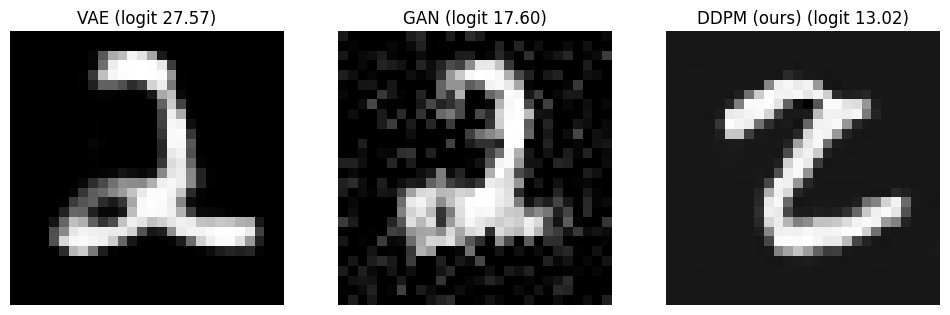

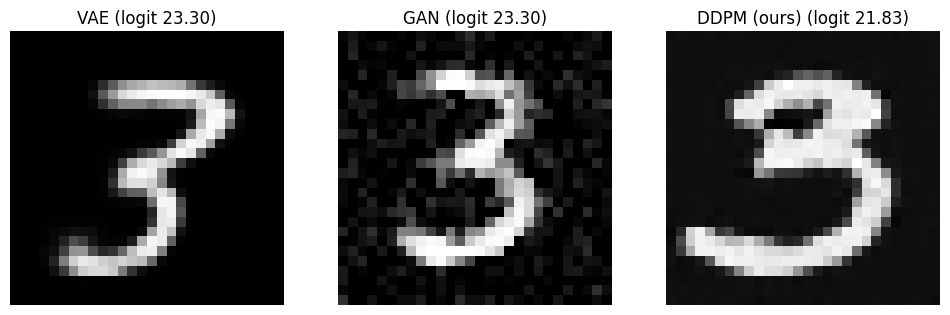

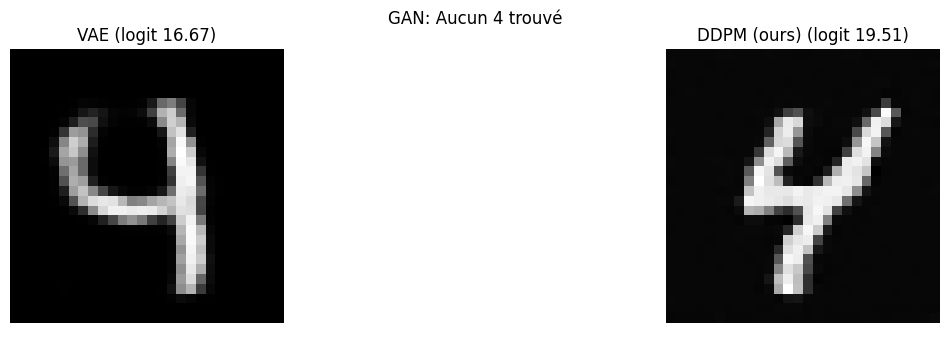

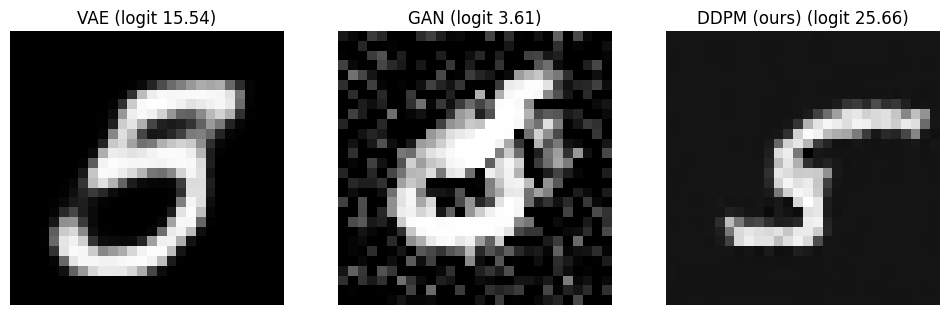

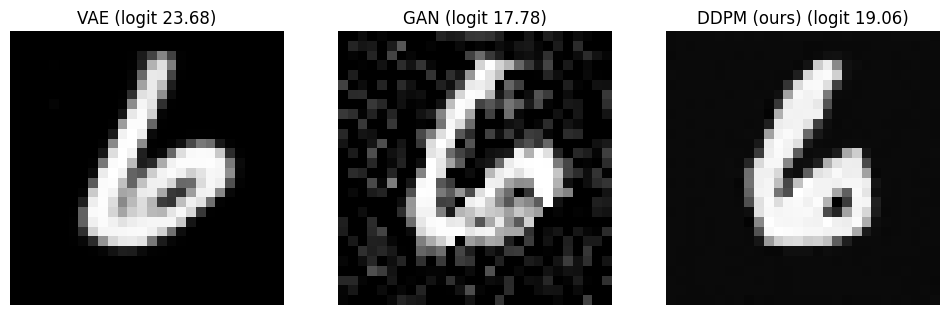

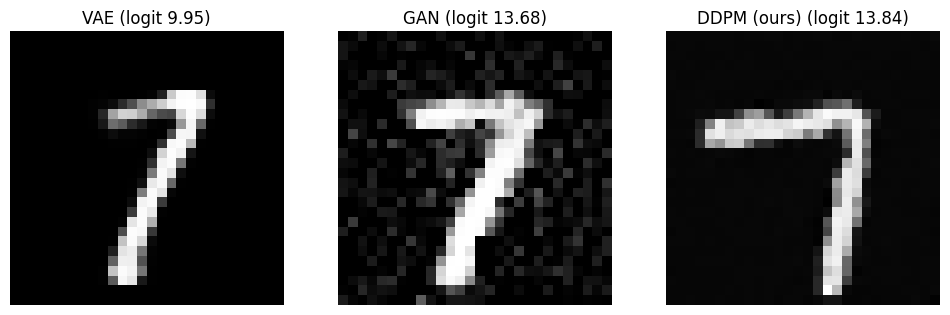

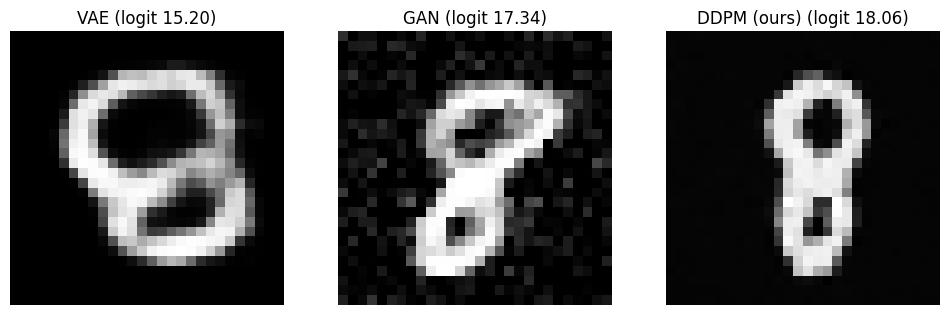

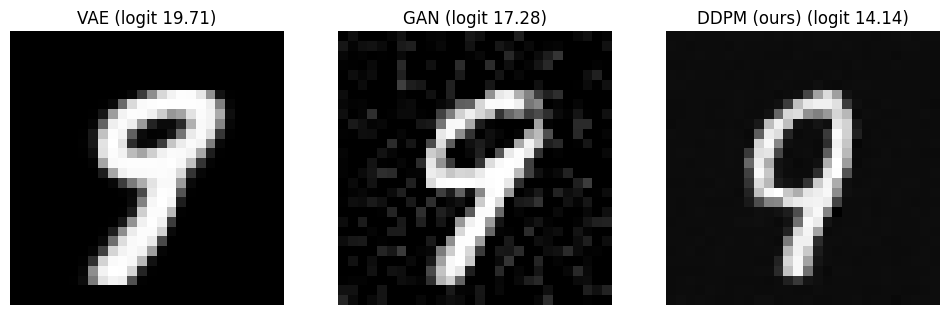

In [90]:
def get_best_generated_digit_from_tensor(model, images, digit, device):
    model.eval()

    best_image = None
    best_logit = -float('inf')  # Très petit au départ

    with torch.no_grad():
        for img in images:
            img = img.unsqueeze(0).to(device)  # Ajouter la dimension batch

            outputs = model(img)  # Logits du CNN
            predicted_label = torch.argmax(outputs, dim=1).item()
            max_logit = outputs[0, digit].item()  # Logit pour le chiffre spécifié

            # Vérifier si c'est un 4 et si son logit est le plus grand trouvé
            if predicted_label == digit and max_logit > best_logit:
                best_logit = max_logit
                best_image = img.squeeze(0).cpu()  # Retirer la batch dim

    return best_image, best_logit

for digit in range(10):

    # Récupérer les meilleures images pour chaque modèle
    vae_best_img, vae_best_logit = get_best_generated_digit_from_tensor(classifier, vae_images, digit, device)
    gan_best_img, gan_best_logit = get_best_generated_digit_from_tensor(classifier, gan_images, digit, device)
    ddpm_best_img, ddpm_best_logit = get_best_generated_digit_from_tensor(classifier, ddpm_images, digit, device)

    # Afficher les meilleures images du chiffre
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for ax, img, title, logit in zip(axes,
                                      [vae_best_img, gan_best_img, ddpm_best_img],
                                      ["VAE", "GAN", "DDPM (ours)"],
                                      [vae_best_logit, gan_best_logit, ddpm_best_logit]):
        if img is not None:
            ax.imshow(img.squeeze(), cmap="gray")
            ax.set_title(f"{title} (logit {logit:.2f})")
        else:
            ax.set_title(f"{title}: Aucun 4 trouvé")

        ax.axis("off")

        plt.savefig(f"./bests/best{digit}")

